In [41]:
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier

sns.set(font_scale=1.4)

In [42]:
file_train_node = 'train.csv'
file_train_feat = 'user_features.csv'
file_test_node = 'test.csv'

In [43]:
nrows = 10000
random_state = 1990

In [44]:
train_node = pd.read_csv(file_train_node, nrows=nrows)
train_feat = pd.read_csv(file_train_feat, nrows=nrows)

test_node = pd.read_csv(file_test_node, nrows=nrows)

In [45]:
def feat_prev_pings(tr_nd):
    inverted_train_node = train_node.rename(
        columns={'node1_id':'node2_id', 'node2_id':'node1_id'}).set_index(
        ['node1_id', 'node2_id'])
    return tr_nd[['node1_id', 'node2_id']].set_index(
        ['node1_id', 'node2_id']).join(inverted_train_node).fillna(0).values.astype(np.int8)

In [46]:
def feat_node_fs(tr_nd, tr_ft):
    n1_cols = {f: f'{f}_n1' for f in tr_ft.columns if 'f' in f}
    n1_cols['index'] = 'node1_id'
    n2_cols = {f: f'{f}_n2' for f in tr_ft.columns if 'f' in f}
    n2_cols['index'] = 'node2_id'
    n1_df = tr_nd.set_index('node1_id')\
    .join(tr_ft.set_index('node_id'))\
    .reset_index()\
    .rename(columns=n1_cols)
    df = n1_df.set_index('node2_id')\
    .join(tr_ft.set_index('node_id'))\
    .reset_index()\
    .rename(columns=n2_cols)
    return df

In [47]:
train = train_node.copy()
train['prev_is_chat'] = feat_prev_pings(train_node)

In [48]:
train = feat_node_fs(train, train_feat)

In [49]:
train.head()

,node2_id,node1_id,is_chat,prev_is_chat,f1_n1,f2_n1,f3_n1,f4_n1,f5_n1,f6_n1,...,f4_n2,f5_n2,f6_n2,f7_n2,f8_n2,f9_n2,f10_n2,f11_n2,f12_n2,f13_n2
0,72,7727688,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
1,278,5845081,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,14.0,2.0,31.0,15.0,1.0,31.0,19.0,2.0,15.0
2,451,2693495,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,0.0,0.0,31.0,0.0,0.0,31.0,1.0,0.0,4.0
3,508,6434284,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,5.0,1.0,31.0,4.0,0.0,31.0,1.0,0.0,4.0
4,881,4659861,0,0,NaN,NaN,NaN,NaN,NaN,NaN,...,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,15.0


In [50]:
train.to_csv('train_features.csv', index=False)

In [51]:
ids = ['node1_id', 'node2_id']
label = 'is_chat'
features = [col for col in train.columns if col not in ids and col != label]

In [52]:
rf = RandomForestClassifier(n_jobs=4, max_depth=10, n_estimators=200, random_state=random_state)

In [55]:
zero_train = train[train.is_chat==0].sample(train[train.is_chat==1].shape[0]*2)
one_train = train[train.is_chat==1]

In [63]:
sample_train = pd.concat([zero_train, one_train])
sample_train = sample_train.sample(frac=1).reset_index(drop=True)
sample_train.to_csv('sample_train.csv', index=False)
sample_train = sample_train.dropna()

In [64]:
rf.fit(sample_train[features], sample_train[label])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=4,
            oob_score=False, random_state=1990, verbose=0,
            warm_start=False)

In [65]:
rf.feature_importances_

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

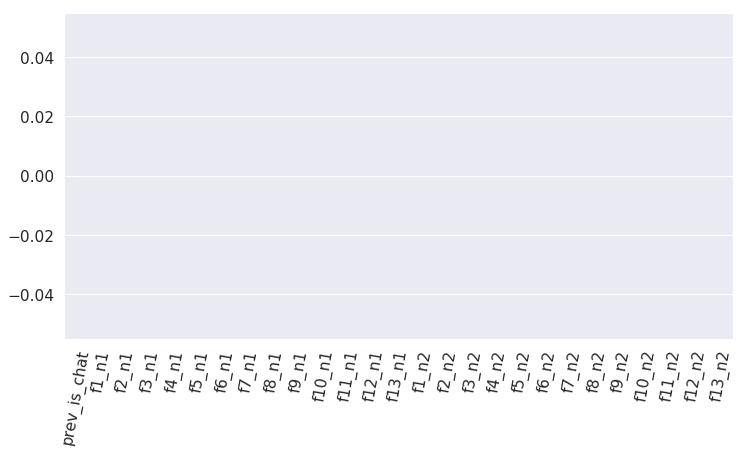

In [66]:
plt.figure(figsize=(12, 6));
sns.barplot(x=features, y=rf.feature_importances_);
plt.xticks(rotation=80);

In [67]:
with open('rf_v1.pkl', 'wb') as f:
    pickle.dump(rf, f)